# An Exploration of Bias Mitigation

*Manish Nagireddy*

A deep look through various aspects of fairness accociated with the different steps in the machine learning pipeline (https://media.arxiv-vanity.com/render-output/2987698/x1.png)

Utilized data from: https://www.kaggle.com/jyzaguirre/us-homicide-reports

Goal: predict either sex or skin color of perpetrator based on US Homicide Reports 1980-2014 **and more importantly** see whether model has bias towards either protected attribute.

This project is largely a recreation of a prior notebook and serves mainly to explore the AIF360 toolkit

The original notebook can be found here: https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml/notebook?select=database.csv

# Table of Contents #

* <a href="#1">1. Project Preparation</a>
    * <a href="#1.1"> 1.1 Libraries</a>
    * <a href="#1.2"> 1.2 Data</a>
* <a href="#2">2. EDA</a>
    * <a href="#2.1">2.1 Data Preparation</a>
    * <a href="#2.2">2.2 Missing Values</a>
    * <a href="#2.3">2.3 Visualization</a>
        * <a href="#2.3.1">2.3.1 Numerical Cols</a>
        * <a href="#2.3.2">2.3.2 Categorical Cols</a>
        * <a href="#2.3.3">2.3.3 Dropping Unnecessary Cols</a>
    * <a href="#2.4">2.4 Feature Adjustments</a>
        * <a href="#2.4.1">2.4.1 Encoding Categorical Cols</a>
        * <a href="#2.4.2">2.4.2 Scaling Numerical Cols</a>
        * <a href="#2.4.3">2.4.3 The Encoded Dataset</a>
        * <a href="#2.4.4">2.4.4 A Decoded Dataset for Reference</a>
* <a href="#3">3. AIF360 Introduction</a>
    * <a href="#3.1">3.1 Creating the Dataset</a>
    * <a href="#3.2">3.2 Preliminary Models</a>
* <a href='#4'>4. Bias and Fairness</a>
    * <a href='#4.0'>4.0 Is there Bias?</a>
    * <a href='#4.1'>4.1 Bias Mitigation</a>
        * <a href='#4.1.1'>4.1.1 Pre-Processing Algos </a>
            * <a href='#4.1.1.1'>4.1.1.1 Disparate Impact Remover</a>
            * <a href='#4.1.1.2'>4.1.1.2 Learning Fair Representations</a>
            * <a href='#4.1.1.3'>4.1.1.3 Optimized Preprocessing</a>
            * <a href='#4.1.1.4'>4.1.1.4 Reweighing</a>
        * <a href='#4.1.2'>4.1.2 In-Processing Algos</a>
            * <a href='#4.1.2.1'>4.1.2.1 Adversarial Debiasing</a>
            * <a href='#4.1.2.2'>4.1.2.2 Prejudice Remover</a>
        * <a href='#4.1.3'>4.1.3 Post-Processing Algos</a>
            * <a href='#4.1.3.1'>4.1.3.1 Calibrated Equality of Odds</a>
            * <a href='#4.1.3.2'>4.1.3.2 Equality of Odds</a>
            * <a href='#4.1.3.3'>4.1.3.3 Reject Option Classification</a>
    * <a href='#4.2'>4.2 Algo Fairness Comparison</a>
    * <a href='#4.3'>4.3 Algo Performance Comparison</a>

# <a id = '1'> Project Preparation

### <a id=1.1>1.1 Libraries</a>

Note: if any of the below commands result in errors, just re-run them and make sure the respsctive pacakges have been installed.

Standard Data Science Libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

Machine Learning Libraries

In [89]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

Data Visualization Libraries

In [63]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as pltly
pltly.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

AIF360 Libraries and Packages

In [64]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.preprocessing import lfr_helpers, LFR
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

Design Libraries

In [65]:
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings('ignore')

from time import time

### <a id="1.2">1.2 Data</a>

In [3]:
data = pd.read_csv('database.csv', na_values=['Unknown', ' '])

# <a id="2">2. EDA</a>

### <a id="2.1">2.1 Data Preparation</a>

In [4]:
dataRows, dataCols = data.shape
print('Shape of Dataset\n')
print('Rows:', dataRows, '\nColumns:', dataCols)

Shape of Dataset

Rows: 638454 
Columns: 24


In [5]:
data.head()
#data.head().T where .T means transpose

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,NaN,Male,15.0,Native American/Alaska Native,NaN,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,NaN,Male,42.0,White,NaN,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,NaN,Male,42.0,White,NaN,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,1,FBI


In [6]:
print('Variables: ', data.columns)

Variables:  Index(['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved',
       'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race',
       'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')


**Which variables do we need to drop?**

* Record ID: irrelevant because it is unique and uncorrelated to predictions
* Agency Code: same as Agency Name so not really relevant
* Perpetrator Ethnicity: corresponds to target columns

In [7]:
dropped_cols = ['Record ID', 'Agency Code', 'Perpetrator Ethnicity']
original_data = data.copy()
data.drop(columns=dropped_cols, inplace=True)
dropped_cols = list()

Checking for Missing Values

In [11]:
def print_missing_values(data):
    data_null = pd.DataFrame(len(data) - data.notnull().sum(), columns = ['Count'])
    data_null = data_null[data_null['Count'] > 0].sort_values(by='Count', ascending=False)
    data_null = data_null/len(data)*100

    trace = go.Bar(x=data_null.index, y=data_null['Count'], marker=dict(color='#c0392b'), opacity=0.9)
    layout = go.Layout(barmode='group', title='Columns with at Least 1 Missing Value', showlegend=False,
                   legend=dict(orientation="h"), yaxis=dict(title='Percentage of the dataset'))
    fig = go.Figure([trace], layout=layout)
    pltly.iplot(fig)

In [12]:
print('Total Number of Rows: '+ str(data.shape[0]))
print_missing_values(data)

Total Number of Rows: 638454


In [13]:
data['Crime Solved'].value_counts()

Yes    448172
No     190282
Name: Crime Solved, dtype: int64

Note: in order to predict sex and skin color, need to drop cases where crimes were **not** solved

In [14]:
original_data = data.copy()

data = data[data['Crime Solved'] == 'Yes']
dropped_cols += ['Crime Solved']

Need to encode 'Perpetrator Age' column to categorical labels where:
* Elder = 65+
* Young = 0-24
* Adult = 25-64

In [15]:
data['Perpetrator Age Categorical'] = np.where(data['Perpetrator Age'] > 64, 
                                            'Elder', np.where(data['Perpetrator Age'] < 25, 'Young', 'Adult'))
#np.where is like an if-else case
    #the first parameter is the dataset to examine
    #the second parameter is what the classification should be
    #the last two parameters are (in order), 'young' if the second .where is true, "adult" if false

In [16]:
y_cols = ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age Categorical']
ignore_cols = ['Crime Solved']
cat_columns = [] #categorical vars
num_columns = [] #numerical vars

for col in data.columns.values:
    if col in y_cols + ignore_cols:
        continue
    elif data[col].dtypes == 'int64':
        num_columns += [col]
    else:
        cat_columns += [col]



### <a id="2.2">2.2 Missing Values</a>

Two Cases
* Quantitative (Numerical) Values: replace with mean of column
* Categorical Values: Replace with 'Missing Value' 

In [17]:
median = pd.Series()
#Series is a one-dimensional labeled array 
#capable of holding data of any type (integer, string, float, python objects, etc.)

for col in num_columns:
    if col not in dropped_cols:
        median[col] = data[col].median()

/Users/manishn/cfpb-venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [18]:
def handleMissingVals(data, median):
    df = data.copy()
    for col in df:
        if col in median.index.values: #if col is a numerical value
            df[col] = df[col].fillna(median[col])
        else: #col is a categorical value
            df[col] = df[col].fillna("Missing Value")
    return df

In [19]:
data = handleMissingVals(data, median)

In [20]:
data.head()

,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Perpetrator Age Categorical
0,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,Yes,Male,...,Missing Value,Male,15.0,Native American/Alaska Native,Acquaintance,Blunt Object,0,0,FBI,Young
1,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,Yes,Male,...,Missing Value,Male,42.0,White,Acquaintance,Strangulation,0,0,FBI,Adult
3,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,Yes,Male,...,Missing Value,Male,42.0,White,Acquaintance,Strangulation,0,0,FBI,Adult
5,Anchorage,Municipal Police,Anchorage,Alaska,1980,May,1,Murder or Manslaughter,Yes,Male,...,Missing Value,Male,36.0,White,Acquaintance,Rifle,0,0,FBI,Adult
6,Anchorage,Municipal Police,Anchorage,Alaska,1980,May,2,Murder or Manslaughter,Yes,Female,...,Missing Value,Male,27.0,Black,Wife,Knife,0,0,FBI,Adult


### <a id="2.3">2.3 Visualization</a>

#### <a id="2.3.1">2.3.1 Numerical Cols</a> 

In [21]:
def target_distribution(y_var, data):
    val = data[y_var]

    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    count = val.value_counts().sort_values(ascending=True)
    labels = count.index.values

    sizes = count.values
    colors = sns.color_palette("cubehelix", len(labels))

    #Bar Graph
    ax1.barh(count.index.values, count.values, color=colors)
    ax1.set_title('Count of '+ y_var)

    #Pie Chart
    ax2.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%', shadow=True, startangle=200)
    ax2.axis('equal')
    ax2.set_title('Percentage of '+ y_var)
    plt.show()

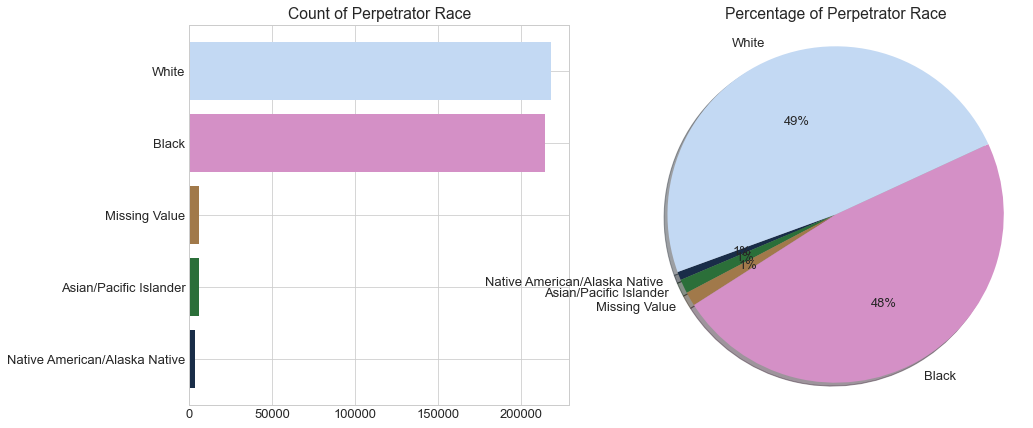

In [22]:
label = 'Perpetrator Race'
target_distribution(y_var=label, data=data)

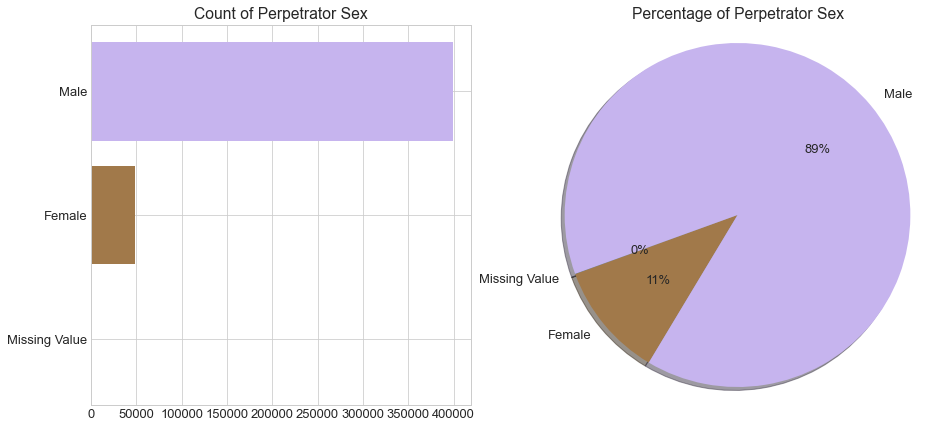

In [23]:
label = 'Perpetrator Sex'
target_distribution(y_var=label, data=data)

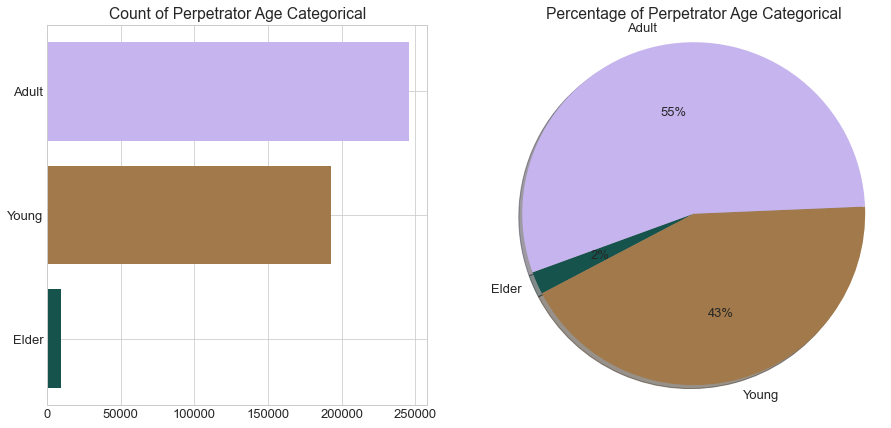

In [24]:
label = 'Perpetrator Age Categorical'
target_distribution(y_var=label, data=data)

In [25]:
data['Frequency'] = 1
freq_target = data[['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age Categorical', 'Frequency']]
del data['Frequency']
freq_target = freq_target.groupby(by=['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age Categorical']).count() / len(data)
print(freq_target.sort_values(by='Frequency', ascending = False))

                                                                           Frequency
Perpetrator Sex Perpetrator Race              Perpetrator Age Categorical           
Male            White                         Adult                         0.264265
                Black                         Young                         0.220366
                                              Adult                         0.197418
                White                         Young                         0.159222
Female          Black                         Adult                         0.035841
                White                         Adult                         0.034741
                Black                         Young                         0.018415
                White                         Young                         0.013767
Male            White                         Elder                         0.013439
                Missing Value                 Young              

This tells us that there is ~ 25% chance the perpetrator is a **white adult man**

In [26]:
def plot_histo(data, col, y_cols):
    df = data.copy()
    fig, axis = plt.subplots(1,2,figsize=(20,6))
    
    for i in range(0,2):
        count = []; 
        y_col = y_cols[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            count += [df[df[y_col] == val][col].values]
        bins = df[col].nunique()

        axis[i].hist(count, bins=bins, stacked=True)
        axis[i].legend(Y_values,loc='upper right')
        axis[i].set_title(col +" by "+ y_col)

    plt.show()

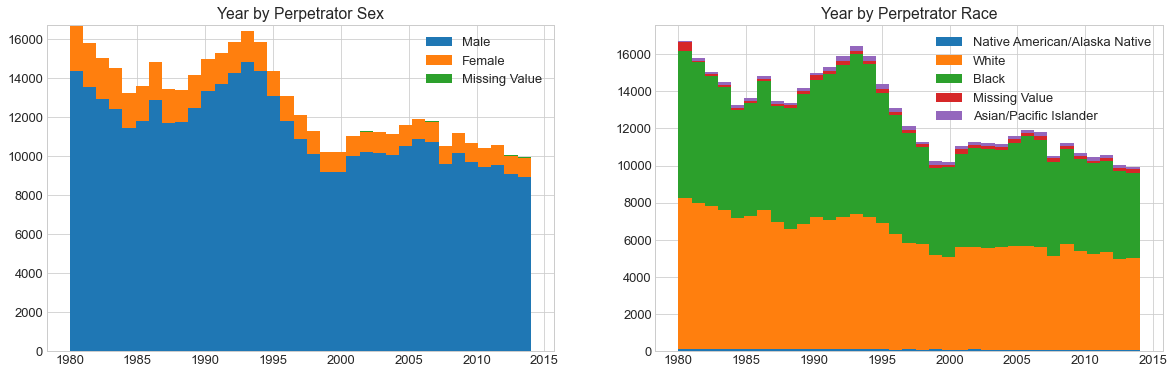

In [27]:
plot_histo(data, col = 'Year', y_cols=y_cols)

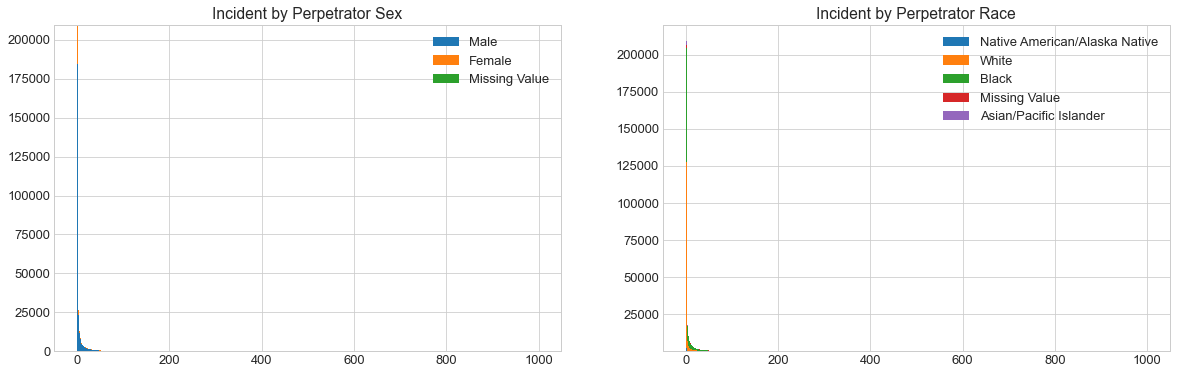

In [28]:
plot_histo(data, col= 'Incident', y_cols = y_cols)

Let's drop the 'Incident' Column as it appears to be difficult to use

In [29]:
dropped_cols += ['Incident']

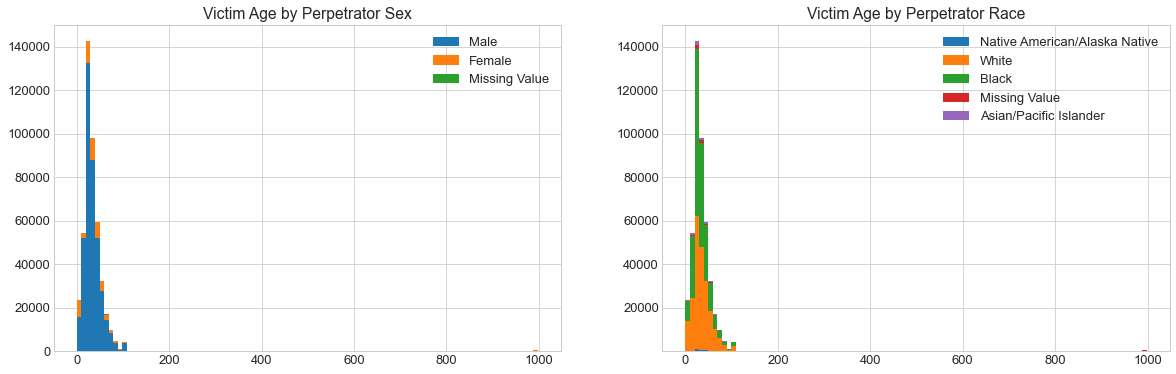

In [30]:
plot_histo(data, col= 'Victim Age',y_cols = y_cols)

These histograms show us that there are definitely some *outliers* that we need to handle

In [31]:
data[data['Victim Age'] > 100]['Victim Age'].value_counts()
#.value_counts returns the count (right number) of all the unique values (left numbers)

998    369
Name: Victim Age, dtype: int64

Clearly, 998 years old people are a mistake, so we have to adjust them by setting them equal to the median

In [32]:
data['Victim Age'] = np.where(data['Victim Age'] == 998, 
                              np.median(data[data['Victim Age'] <= 100]['Victim Age']), data['Victim Age'])

In [33]:
#data[data['Victim Age'] > 100]['Victim Age'].value_counts()
#shows there are no more values with the 998 age

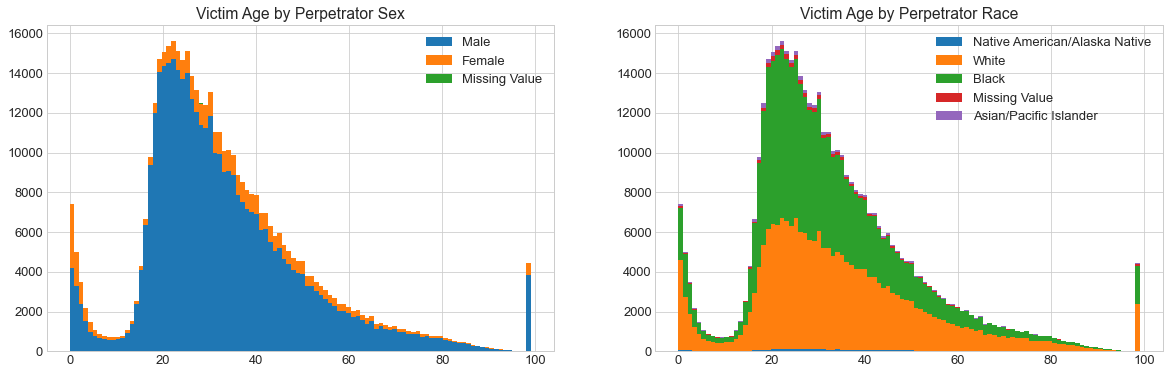

In [34]:
plot_histo(data, col= 'Victim Age',y_cols = y_cols)

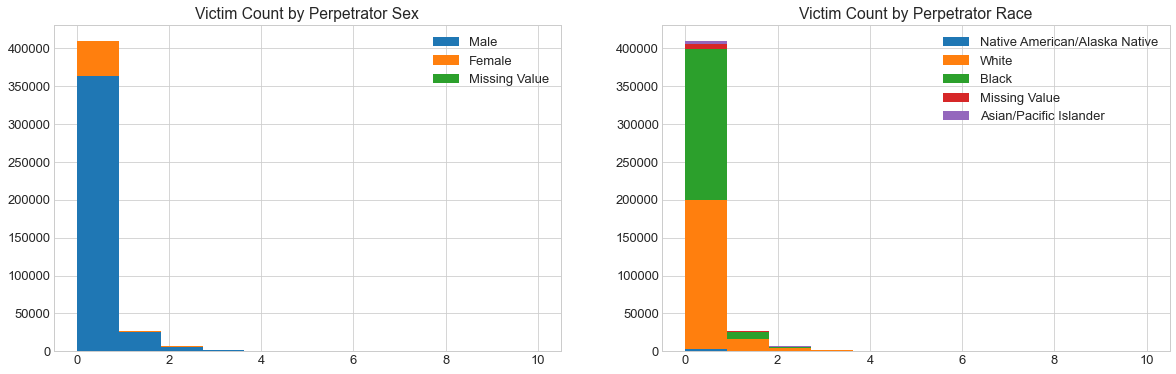

In [35]:
plot_histo(data, col= 'Victim Count',y_cols = y_cols)

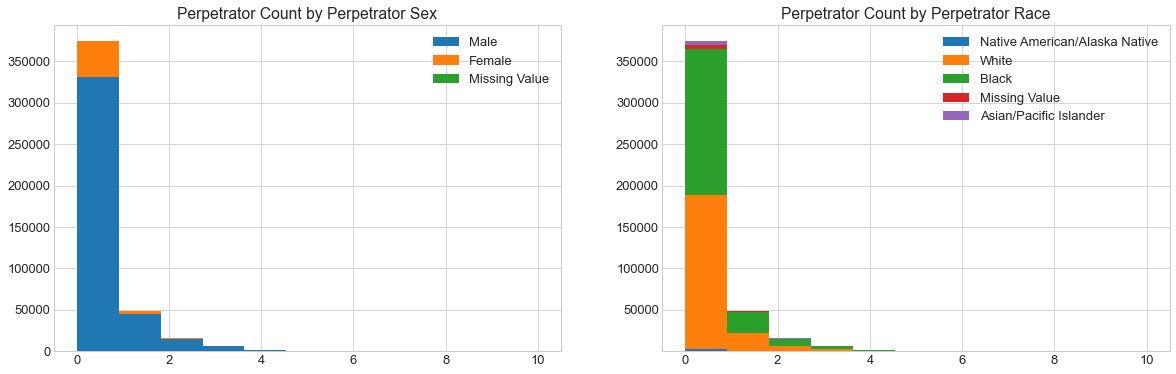

In [36]:
plot_histo(data, col= 'Perpetrator Count',y_cols = y_cols)

#### <a id="2.3.2">2.3.2 Categorical Cols</a> 

In [37]:
cat_columns

['Agency Name',
 'Agency Type',
 'City',
 'State',
 'Month',
 'Crime Type',
 'Victim Sex',
 'Victim Race',
 'Victim Ethnicity',
 'Perpetrator Age',
 'Relationship',
 'Weapon',
 'Record Source']

In [38]:
def plot_bar(data, col, y_cols, max_cat=10, loc = 'upper right'):
    df = data.copy()
    
    fig, axis = plt.subplots(1,2,figsize=(20,6))
    cat_val = df[col].value_counts()[0:max_cat].index.values
    df = df[df[col].isin(cat_val)]

    for i in range(0,2):
        y_col = y_cols[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt = df[df[y_col] == val][col].value_counts().sort_index()
            axis[i].barh(cnt.index.values, cnt.values)
        axis[i].legend(Y_values,loc=loc)
        axis[i].set_title(col + " by " + y_col)

    plt.show()

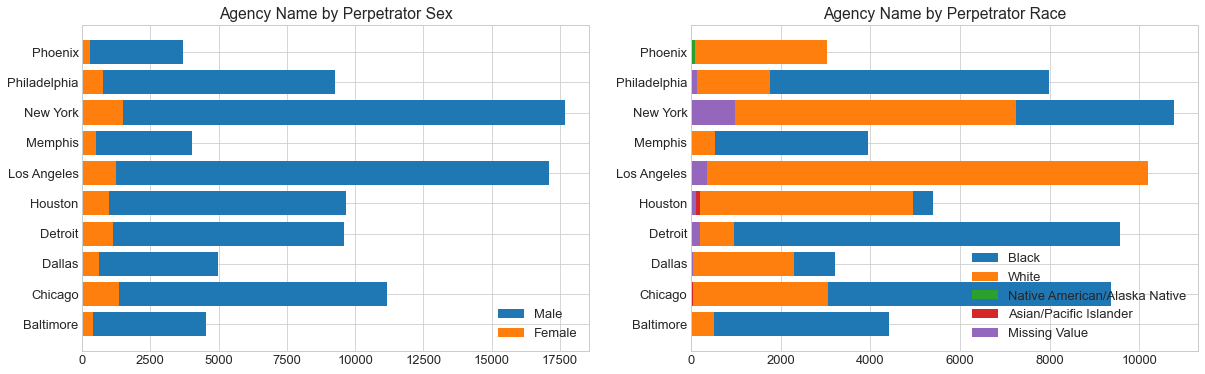

In [39]:
plot_bar(data, col='Agency Name',y_cols=y_cols, loc = 'lower right')

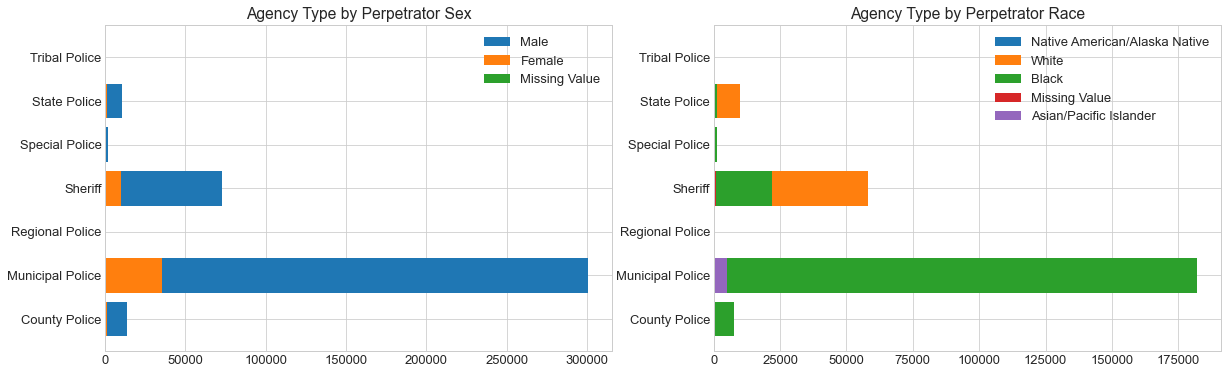

In [40]:
plot_bar(data, col='Agency Type',y_cols=y_cols)

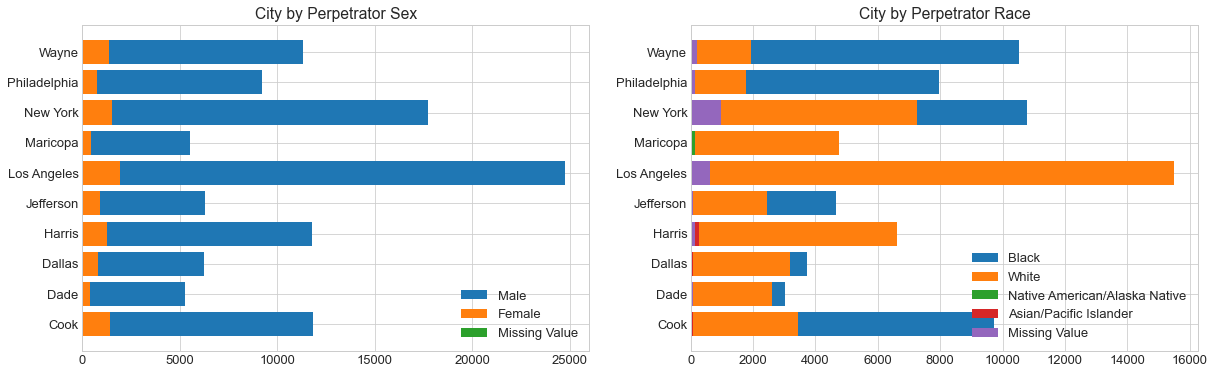

In [41]:
plot_bar(data, col='City',y_cols=y_cols, loc='lower right')

Note: be wary of **bias** for City column because some cities have disproportionately more white perpetrators

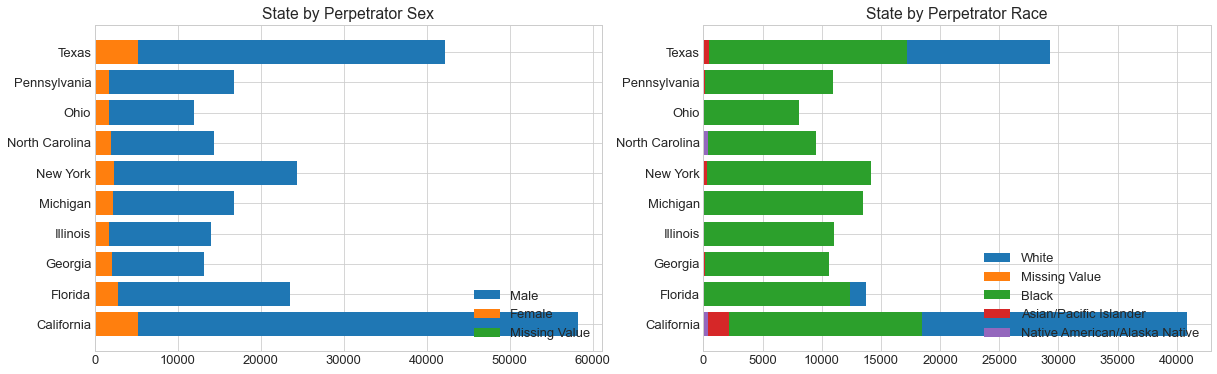

In [42]:
plot_bar(data, col='State',y_cols=y_cols, loc='lower right')

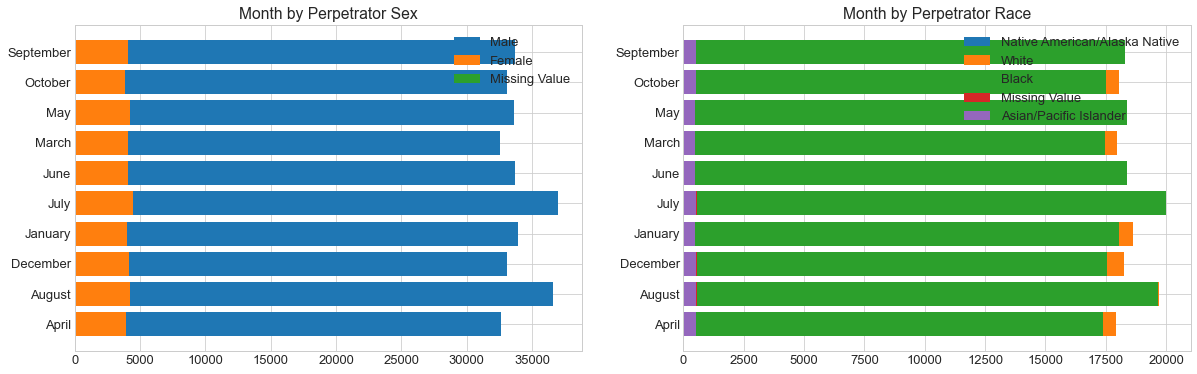

In [43]:
plot_bar(data, col='Month',y_cols=y_cols)

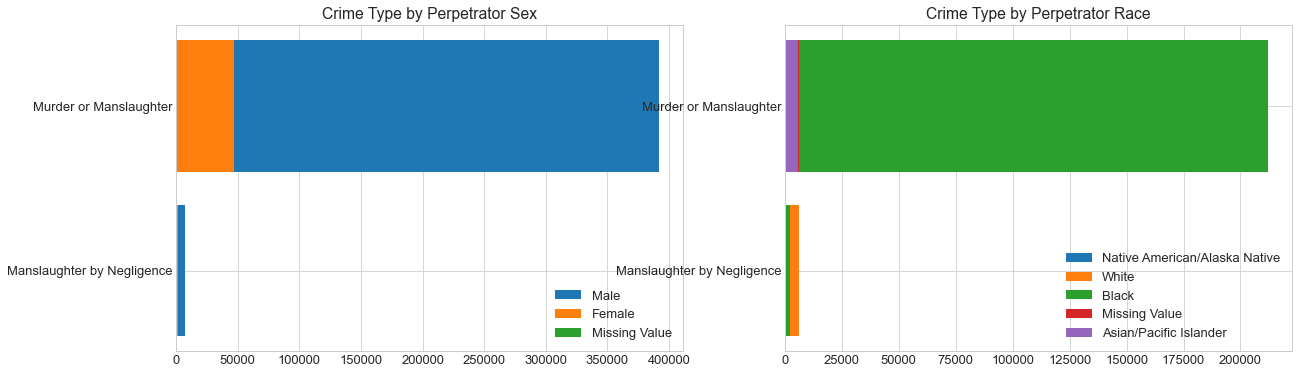

In [44]:
plot_bar(data, col='Crime Type',y_cols=y_cols, loc = 'lower right')

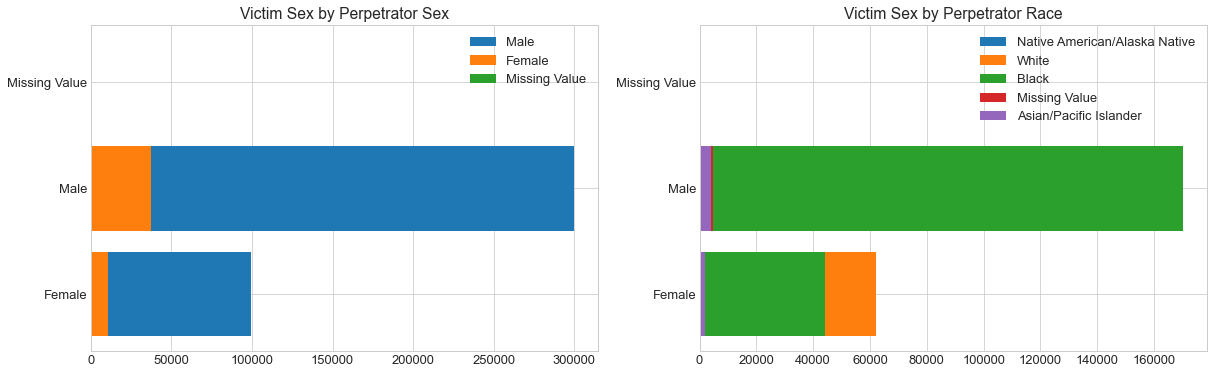

In [45]:
plot_bar(data, col='Victim Sex',y_cols=y_cols)

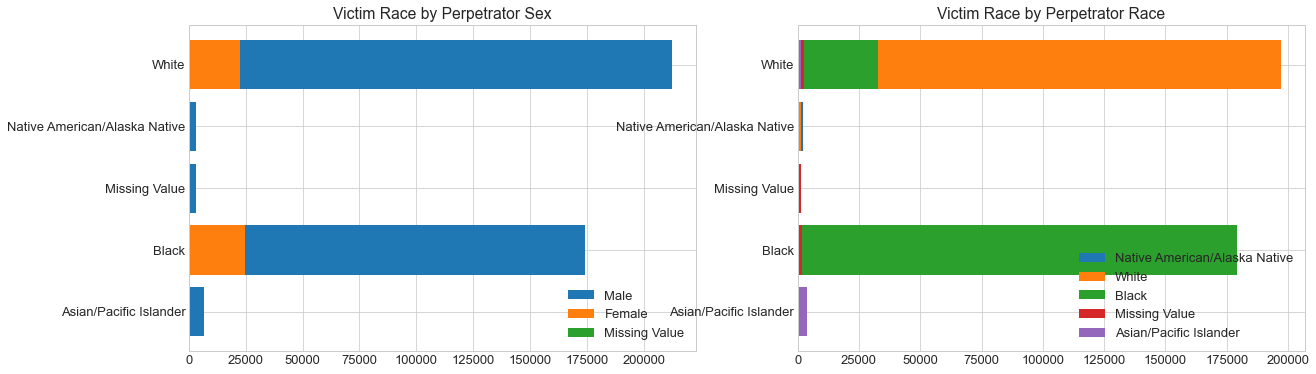

In [46]:
plot_bar(data, col='Victim Race',y_cols=y_cols, loc = 'lower right')

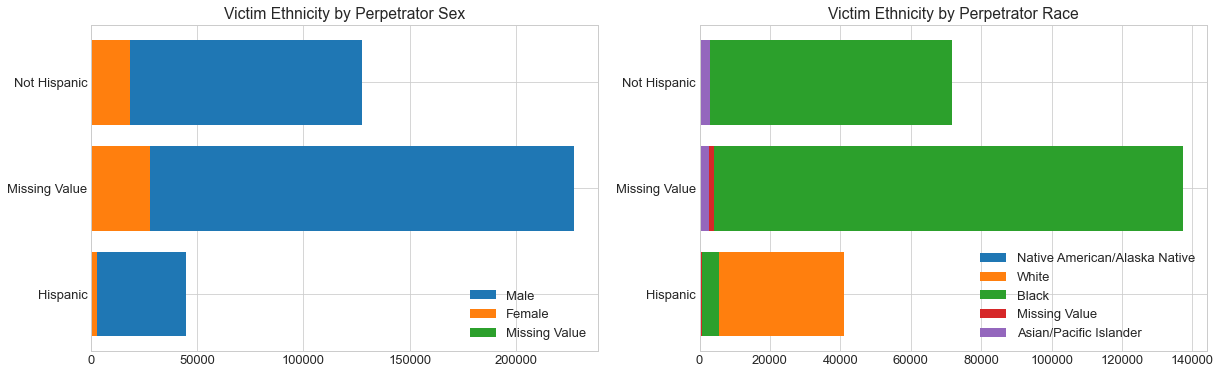

In [47]:
plot_bar(data, col='Victim Ethnicity',y_cols=y_cols, loc = 'lower right')

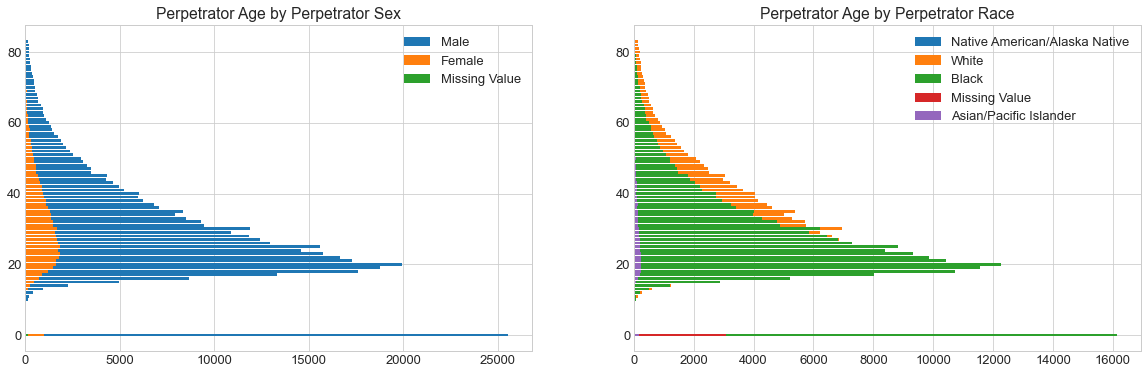

In [48]:
plot_bar(data, col='Perpetrator Age',y_cols=y_cols)

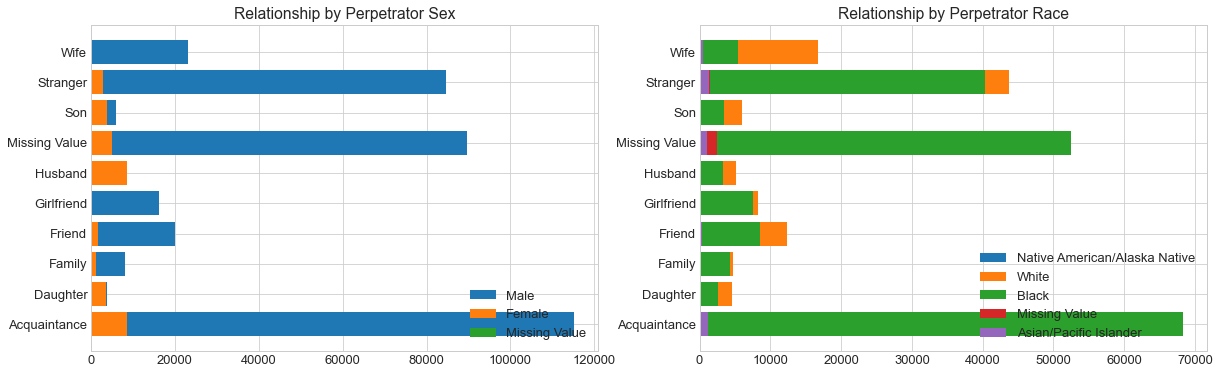

In [49]:
plot_bar(data, col='Relationship',y_cols=y_cols, loc='lower right')

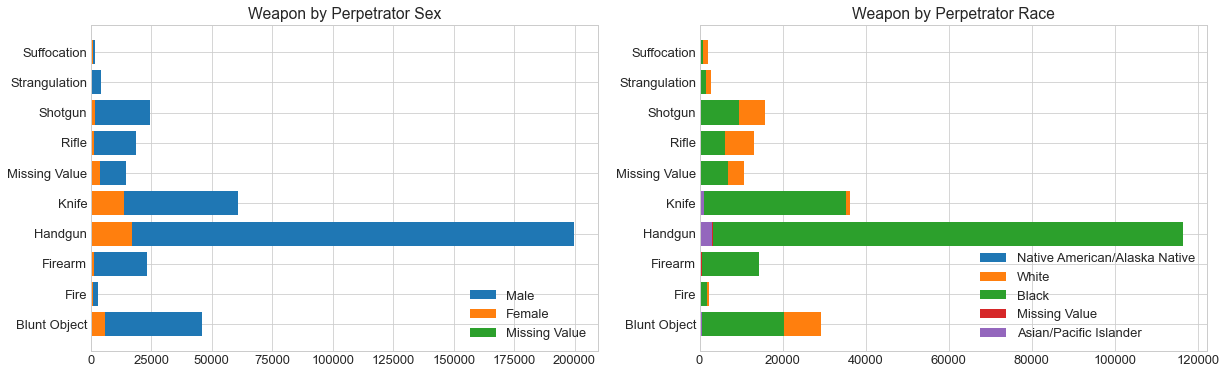

In [50]:
plot_bar(data, col='Weapon',y_cols=y_cols, loc = 'lower right')

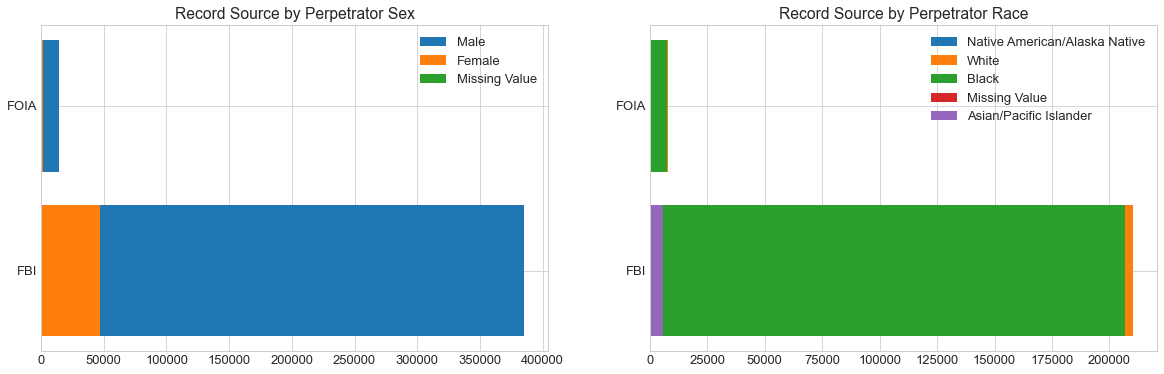

In [51]:
plot_bar(data, col='Record Source',y_cols=y_cols)

#### <a id="2.3.3">2.3.3 Dropping Unnecessary Cols</a> 

In [52]:
data.drop(dropped_cols, axis=1, inplace=True)

### <a id="2.4">2.4 Feature Adjustments</a>

#### <a id="2.4.1">2.4.1 Encoding Categorical Cols</a>

In [53]:
categorical_features = cat_columns + ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age Categorical']

categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

del cat_columns

In [54]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    #see which categorical cols are encoded to which indices
    mappings, mapIndices = pd.Series(categorical_features).factorize()
    #mapIndices.get_loc("Victim Race")
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

Example of how to check label encodings:

In [55]:
for x in range(len(original_data['Victim Race'].unique())):
    print(original_data['Victim Race'].unique()[x], "is encoded to", data_encoded['Victim Race'].unique()[x])
    
print('')
    
for x in range(len(original_data['Victim Sex'].unique())):
    print(original_data['Victim Sex'].unique()[x], "is encoded to", data_encoded['Victim Sex'].unique()[x])

#print(original_data['Victim Race'].unique())
#print(data_encoded['Victim Race'].unique())

Native American/Alaska Native is encoded to 3
White is encoded to 4
Black is encoded to 1
nan is encoded to 2
Asian/Pacific Islander is encoded to 0

Male is encoded to 1
Female is encoded to 0
nan is encoded to 2


#### <a id="2.4.2">2.4.2 Scaling Numerical Cols</a>

In [56]:
numerical_features = [c for c in data.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

del num_columns

#### <a id="2.4.3">2.4.3 The Encoded Dataset</a>

In [57]:
data_encoded.head()

,Agency Name,Agency Type,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Perpetrator Age Categorical
0,146.0,1.0,35.0,1.0,0.0,4.0,1.0,1.0,0.141414,3.0,1.0,1.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0
1,146.0,1.0,35.0,1.0,0.0,7.0,1.0,1.0,0.434343,4.0,1.0,1.0,42.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0
3,146.0,1.0,35.0,1.0,0.0,0.0,1.0,1.0,0.434343,4.0,1.0,1.0,42.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0
5,146.0,1.0,35.0,1.0,0.0,8.0,1.0,1.0,0.303030,4.0,1.0,1.0,36.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0
6,146.0,1.0,35.0,1.0,0.0,8.0,1.0,0.0,0.424242,3.0,1.0,1.0,27.0,1.0,27.0,9.0,0.0,0.0,0.0,0.0


#### <a id="2.4.4">2.4.4 A Decoded Dataset for Reference</a>

In [58]:
def decode_dataset(data, encoders, numerical_features, categorical_features):
    df = data.copy()
    for feat in df.columns.values:
        if feat in numerical_features:
            df[feat] = encoders[feat].inverse_transform(np.array(df[feat]).reshape(-1, 1))
    for feat in categorical_features:
        df[feat] = encoders[feat].inverse_transform(df[feat].astype(int))
    return df

In [59]:
decode_dataset(data_encoded, encoders=encoders, numerical_features=numerical_features, categorical_features=categorical_features).head()

,Agency Name,Agency Type,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Perpetrator Age Categorical
0,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,January,Murder or Manslaughter,Male,14.0,Native American/Alaska Native,Missing Value,Male,15.0,Native American/Alaska Native,Acquaintance,Blunt Object,0.0,0.0,FBI,Young
1,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,March,Murder or Manslaughter,Male,43.0,White,Missing Value,Male,42.0,White,Acquaintance,Strangulation,0.0,0.0,FBI,Adult
3,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,April,Murder or Manslaughter,Male,43.0,White,Missing Value,Male,42.0,White,Acquaintance,Strangulation,0.0,0.0,FBI,Adult
5,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,May,Murder or Manslaughter,Male,30.0,White,Missing Value,Male,36.0,White,Acquaintance,Rifle,0.0,0.0,FBI,Adult
6,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,May,Murder or Manslaughter,Female,42.0,Native American/Alaska Native,Missing Value,Male,27.0,Black,Wife,Knife,0.0,0.0,FBI,Adult


# <a id="3">3. AIF360 Introduction</a>

### <a id="3.1">3.1 Creating the Dataset</a>

In [60]:
dataPerpSex = data_encoded.drop(['Perpetrator Race', 'Perpetrator Age Categorical', 'Perpetrator Age'],
                                  axis=1)
#need to drop the two target variables as well as the one we created

In [61]:
#need to identify privileged classes for AIF360 Dataset object
privileged_sex = np.where(categorical_names['Victim Sex'] == 'Male')[0]
privileged_race = np.where(categorical_names['Victim Race'] == 'White')[0]

In [66]:
dataOrigSex = StandardDataset(dataPerpSex,
                             label_name = 'Perpetrator Sex',
                             favorable_classes=[1],
                             protected_attribute_names=['Victim Sex', 'Victim Race'],
                             privileged_classes=[privileged_sex, privileged_race])

In [67]:
#data_encoded['Victim Race'].value_counts()

In [68]:
#to make sure we know which encodings map to which labels

#data[data['Victim Race'] == 'Missing Value'].count

In [69]:
def meta_data(dataset):
    
    display(Markdown("#### Dataset Shape (rows, cols)"))
    print(dataset.features.shape)
    
    display(Markdown("#### Favorable and Unfavorable labels"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    
    display(Markdown("#### Protected Attribute Names"))
    print(dataset.protected_attribute_names)
    
    display(Markdown("#### Privileged Protected Attribute Value for Victim Sex"))
    print(dataset.privileged_protected_attributes[0], "where 1 means Male from our encoding")
    display(Markdown("#### Privileged Protected Attribute Value for Victim Race"))
    print(dataset.privileged_protected_attributes[1], "where 4 means White from our encoding")

    display(Markdown("#### Unprivileged Protected Attribute Values for Victim Sex"))
    print(dataset.unprivileged_protected_attributes[0], 
          'where 0 means Female and 2 means missing from our encoding\n')
    print(dataset.unprivileged_protected_attributes[1], 
          'where 0 means Asian/Pacific Islander, 1 means Black, 2 means Missing Value,\n' + 
          '3 means Native American/Alaskan Native from our encoding')
    
    display(Markdown("#### Dataset Feature Names"))
    print(dataset.feature_names)

In [70]:
meta_data(dataOrigSex)

#### Dataset Shape (rows, cols)

(448172, 16)


#### Favorable and Unfavorable labels

1.0 0.0


#### Protected Attribute Names

['Victim Sex', 'Victim Race']


#### Privileged Protected Attribute Value for Victim Sex

[1.] where 1 means Male from our encoding


#### Privileged Protected Attribute Value for Victim Race

[4.] where 4 means White from our encoding


#### Unprivileged Protected Attribute Values for Victim Sex

[0. 2.] where 0 means Female and 2 means missing from our encoding

[0. 1. 2. 3.] where 0 means Asian/Pacific Islander, 1 means Black, 2 means Missing Value,
3 means Native American/Alaskan Native from our encoding


#### Dataset Feature Names

['Agency Name', 'Agency Type', 'City', 'State', 'Year', 'Month', 'Crime Type', 'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity', 'Relationship', 'Weapon', 'Victim Count', 'Perpetrator Count', 'Record Source']


### <a id="3.2">3.2 Preliminary Models</a>

#### Splitting into training and test sets

In [71]:
dataOrigSexTrain, dataOrigSexTest = dataOrigSex.split([0.7], shuffle=True)

In [72]:
display(Markdown("#### Training Dataset Shape (rows, cols)"))
print("Perpetrator Sex :",dataOrigSexTrain.features.shape)
display(Markdown("#### Test Dataset Shape (rows, cols)"))
print("Perpetrator Sex :",dataOrigSexTest.features.shape)

#### Training Dataset Shape (rows, cols)

Perpetrator Sex : (313720, 16)


#### Test Dataset Shape (rows, cols)

Perpetrator Sex : (134452, 16)


#### Random Forest Classifier

In [73]:
randForestOrigSex = RandomForestClassifier().fit(dataOrigSexTrain.features,
                                                dataOrigSexTrain.labels.ravel(),
                                                sample_weight = dataOrigSexTrain.instance_weights)

#.ravel() makes all of the labels into a flat, 1-D array

In [74]:
#### Test Set Prediction

In [75]:
xTestSex = dataOrigSexTest.features
yTestSex = dataOrigSexTest.labels.ravel()

#### Model Performance

In [76]:
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 0] #change 0 to 1 if looking at cell immediately below, otherwise need it for final fairness calculations
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc="lower right")

#### Accuracy of the model :

0.9340954392645703


#### F1 score of the model :

0.9640866847969262


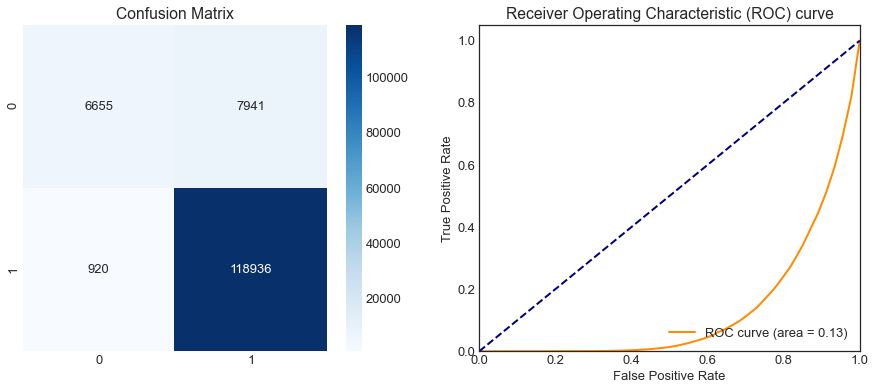

In [77]:
plot_model_performance(randForestOrigSex, dataOrigSexTest.features, yTestSex)

# <a id='4'>4. Bias and Fairness</a>

### <a id='4.0'>4.0 Is there Bias?</a>

Need to create a DataFrame to keep track of different models, metrics, predictions, etc. that will be produced later on.

In [78]:
aif_frame = pd.DataFrame(columns = ['model', 'fair_metrics', 'prediction', 'probabilities'])

def add_to_aif_frame(aif_frame, model, fair_metrics, preds, probs, name):
    return aif_frame.append(pd.DataFrame(data = [[model, fair_metrics, preds, probs]], 
                                         columns = ['model', 'fair_metrics', 'prediction', 'probabilities'],
                                         index = [name]))

In [79]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference',
            'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]] 
    #disparate impact is a ratio, so we want it to be 1,
    #all the others are differences so we want them to be 0 for fairness
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.statistical_parity_difference(),
                            classified_metric.equal_opportunity_difference(),
                            classified_metric.average_abs_odds_difference(),
                            metric_pred.disparate_impact(),
                            classified_metric.theil_index()]],
                            columns  = cols,
                            index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness Metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)],
                         y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg,
                    round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3,
                                       facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [80]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    fair = fair_metrics(data, pred)

    if plot:
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Bias Metrics

#### For the Victim Sex attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the Victim Race attribute :

With default thresholds, bias against unprivileged group detected in **0** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.00000,1.000000,0.000000
Victim Sex,0.026802,-0.006159,0.13666,1.028604,0.026912
Victim Race,0.004012,-0.004134,0.02239,1.004215,0.026912


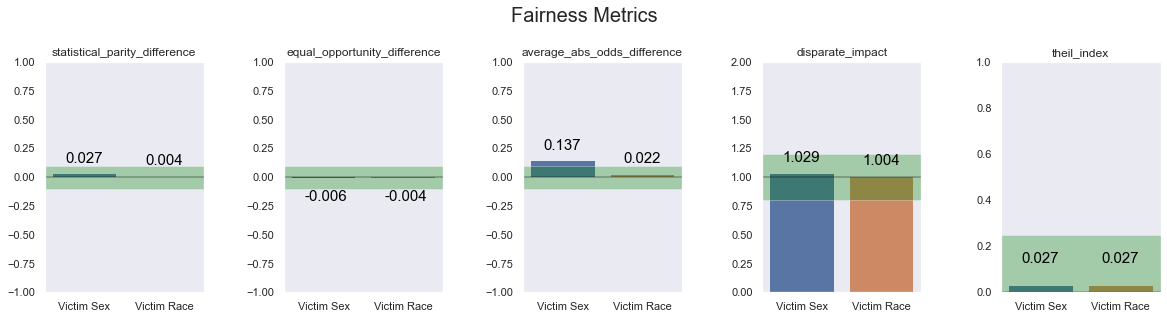

In [81]:
display(Markdown('### Bias Metrics'))
fair = get_fair_metrics_and_plot(dataOrigSexTest, randForestOrigSex)

In [82]:
dataOrigTest = dataOrigSexTest
dataOrigTrain = dataOrigSexTrain
randForest = randForestOrigSex

probs = randForest.predict_proba(dataOrigTest.features)
preds = randForest.predict(dataOrigTest.features)
aif_frame = add_to_aif_frame(aif_frame, randForest, fair, preds, probs, 'Origin')

### <a id='4.1'>4.1 Bias Mitigation</a>

#### <a id='4.1.1'>4.1.1 Pre-Processing Algos</a>

Note: the **only** pre-processing algo that allows for more than one protected attribute at a time is **Reweighing**

In [83]:
def get_attributes(data, selected_attribute = None):
    unprivileged_groups = []
    privileged_groups = []
    if selected_attribute is None:
        selected_attribute = data.protected_attribute_names
    
    for attribute in selected_attribute:
        index = data.protected_attribute_names.index(attribute)
        privileged_groups.append({attribute: data.privileged_protected_attributes[index]})
        unprivileged_groups.append({attribute: data.unprivileged_protected_attributes[index]})
    return privileged_groups, unprivileged_groups

In [84]:
privileged_groups, unprivileged_groups = get_attributes(dataOrigTrain, selected_attribute=['Victim Race'])

##### <a id='4.1.1.1'>4.1.1.1 Disparate Impact Remover</a>

In [ ]:
dispImpactRemover = DisparateImpactRemover(sensitive_attribute='Victim Race')
dataTransfTrainDisp = dispImpactRemover.fit_transform(dataOrigTrain)

In [ ]:
dataTransfTrainDisp.convert_to_dataframe()[0].head()

In [ ]:
dataOrigTrain.convert_to_dataframe()[0].head()

In [ ]:
df3 = pd.DataFrame()
df3['diff'] = dataOrigTrain.convert_to_dataframe()[0]['Victim Race'].sub(dataTransfTrainDisp.convert_to_dataframe()[0]['Victim Race'])
for i in range(len(df3['diff'])):
    if(df3['diff'][i] != 0): print(df3['diff'][i])
print('nothing is different!')

In [ ]:
privileged_groups = [{'Victim Race': 1}]
unprivileged_groups = [{'Victim Race': 0, 'Victim Race': 2, 'Victim Race': 3, 'Victim Race': 4}]

metricDisp1 = BinaryLabelDatasetMetric(dataOrigTrain,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)

metricDisp2 = BinaryLabelDatasetMetric(dataTransfTrainDisp,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)

In [ ]:
print(metricDisp1.mean_difference())
print(metricDisp2.mean_difference())

##### <a id='4.1.1.2'>4.1.1.2 Learning Fair Representations</a>

In [85]:
t0 = time()
LFR_model = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups,
                k=1, verbose=0)

dataTransfTrainLFR = LFR_model.fit_transform(dataOrigTrain)

randForestTransfLFR = RandomForestClassifier().fit(dataTransfTrainLFR.features,
                                                   dataTransfTrainLFR.labels.ravel(),
                                                   sample_weight=dataTransfTrainLFR.instance_weights)

dataTransfTestLFR = LFR_model.transform(dataOrigTest)
fair = get_fair_metrics_and_plot(dataTransfTestLFR, randForestTransfLFR, plot=False)
probs = randForestTransfLFR.predict_proba(dataOrigTest.features)
preds = randForestTransfLFR.predict(dataOrigTest.features)

algo_metrics = add_to_aif_frame(aif_frame, randForestTransfLFR, fair, preds, probs, 'LFR')
print('time elapsed : %.2fs'%(time()-t0))

250 73596747651.00963
500 73596743846.43135
750 73596733817.17014
time elapsed : 53.51s


##### <a id='4.1.1.3'>4.1.1.3 Optimized Preprocessing</a>

Skip this one

##### <a id='4.1.1.4'>4.1.1.4 Reweighing</a>

In [87]:
t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

dataTransfTrainRW = RW.fit_transform(dataOrigTrain)


randForestTransfRW = RandomForestClassifier().fit(dataTransfTrainRW.features, 
                     dataTransfTrainRW.labels.ravel(), 
                     sample_weight=dataTransfTrainRW.instance_weights)

dataTransfTestRW = RW.transform(dataOrigTest)
fair = get_fair_metrics_and_plot(dataOrigTest, randForestTransfRW, plot=False)
probs = randForestTransfRW.predict_proba(dataOrigTest.features)
preds = randForestTransfRW.predict(dataOrigTest.features)

algo_metrics = add_to_aif_frame(algo_metrics, randForestTransfRW, fair, preds, probs, 'Reweighing')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 60.92s


#### <a id='4.1.2'>4.1.2 In-Processing Algos</a>

#####  <a id='4.1.2.1'>4.1.2.1 Adversarial Debiasing</a>

Has a bug, need to fix w.r.t. tensorflow Session()

In [91]:
t0 = time()
sess = tf.Session()
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          num_epochs=10,
                          debias=True,
                          sess=sess)
debiased_model.fit(dataOrigTrain)
fair = get_fair_metrics_and_plot(dataOrigTest, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(dataOrigTest)
algo_metrics = add_to_aif_frame(algo_metrics, debiased_model, fair, data_pred.labels,
                                data_pred.scores, 'Adverserial Debiasing')

print('time elapsed : %.2fs'%(time()-t0))

AttributeError: module 'tensorflow' has no attribute 'Session'

##### <a id='4.1.2.2'>4.1.2.2 Prejudice Remover</a>

In [ ]:
t0 = time()
debiased_model = PrejudiceRemover(sensitive_attr="Victim Race", eta = 25.0)
debiased_model.fit(dataOrigTrain)

fair = get_fair_metrics_and_plot(dataOrigTest, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(dataOrigTest)

algo_metrics = add_to_aif_frame(algo_metrics, debiased_model, fair,
                                      data_pred.labels, data_pred.scores, 'Prejudice Remover')

print('time elapsed : %.2fs'%(time()-t0))

Note: was running for over 20 minutes so had to kill it

#### <a id='4.1.3'>4.1.3 Post-Processing Algos</a>

In [92]:
dataOrigTestPred = dataOrigTest.copy(deepcopy=True)

scores = np.zeros_like(dataOrigTest.labels)
scores = randForest.predict_proba(dataOrigTest.features)[:,1].reshape(-1,1)
dataOrigTestPred.scores = scores

preds = np.zeros_like(dataOrigTest.labels)
preds = randForest.predict(dataOrigTest.features).reshape(-1,1)
dataOrigTestPred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

##### <a id='4.1.3.1'>4.1.3.1 Calibrated Equality of Odds</a>

In [93]:
t0 = time()

cost_constraint = "fnr" # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(dataOrigTest, dataOrigTestPred)
dataTransfTestPredCEqOdds = CPP.predict(dataOrigTestPred)

fair = fair_metrics(dataOrigTest, dataOrigTestPred, pred_is_dataset=True)

algo_metrics = add_to_aif_frame(algo_metrics,
                                CPP, fair, 
                                dataTransfTestPredCEqOdds.labels, 
                                format_probs(dataTransfTestPredCEqOdds.scores), 
                                'Calibrated Equalized Odds')

print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 1.79s


##### <a id='4.1.3.2'>4.1.3.2 Equality of Odds</a>

In [94]:
EOPP = EqOddsPostprocessing(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups,
                             seed=42)
EOPP = EOPP.fit(dataOrigTest, dataOrigTestPred)
dataTransfTestPredEqOdds = EOPP.predict(dataOrigTestPred)

fair = fair_metrics(dataOrigTest, dataOrigTestPred, pred_is_dataset=True)

algo_metrics = add_to_aif_frame(algo_metrics,
                                EOPP, fair, 
                                dataTransfTestPredEqOdds.labels, 
                                format_probs(dataTransfTestPredEqOdds.scores), 
                                'Equalized Odds')

print('time elapsed : %.2fs'%(time()-t0))

ValueError: Invalid input for linprog: c must not contain values inf, nan, or None

##### <a id='4.1.3.3'>4.1.3.3 Reject Option Classification</a>

In [95]:
t0 = time()

ROC = RejectOptionClassification(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups)

ROC = ROC.fit(dataOrigTest, dataOrigTestPred)
dataTransfTestPredROC = ROC.predict(dataOrigTestPred)

fair = fair_metrics(dataOrigTest, dataTransfTestPredROC, pred_is_dataset=True)

algo_metrics = add_to_aif_frame(algo_metrics, ROC, fair, dataTransfTestPredROC.labels, 
                                format_probs(dataTransfTestPredROC.scores), 
                                'RejectOption')

print('time elapsed : %.2fs'%(time()-t0))

IndexError: index 0 is out of bounds for axis 0 with size 0

### <a id='4.2'>4.2 Algo Fairness Comparison</a>

In [96]:
def plot_fair_metrics_plotly(fair_metrics):
    bottom = [-1, -1, -1, 0, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]
    cols = fair_metrics.columns.values

    for i in range(0, 5):
        col = cols[i]

        x, y = (fair_metrics[col].values, fair_metrics.index)
        colors = []
        for v in x:
            color = '#e74c3c' if v < min_valid[i] or v > max_valid[i] else '#2ecc71'
            colors.append(color)

        trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                       , opacity=0.9, orientation='h')

        layout = go.Layout(barmode='group',
                           title=col,
                           xaxis=dict(range=[bottom[i], bottom[i] + 2]),
                           yaxis=go.layout.YAxis(automargin=True),
                           shapes=[
                               {
                                   'type': 'line',
                                   'x0': min_valid[i],
                                   'y0': -1,
                                   'x1': min_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }, {
                                   'type': 'line',
                                   'x0': max_valid[i],
                                   'y0': -1,
                                   'x1': max_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }])
        fig = go.Figure([trace], layout=layout)
        pltly.iplot(fig)

def plot_score_fair_metrics(score):
    display(score.sort_values(['nb_valid', 'score'], ascending=[0, 1]))
    score.sort_values(['nb_valid', 'score'], ascending=[1, 0], inplace=True)

    gold, silver, bronze, other = ('#FFA400', '#bdc3c7', '#cd7f32', '#3498db')
    colors = [gold if i == 0 else silver if i == 1 else bronze if i == 2 else other for i in range(0, len(score))]
    colors = [c for c in reversed(colors)]

    x, y = (score['score'].values, score.index)

    trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                   , opacity=0.9, orientation='h')
    layout = go.Layout(barmode='group',
                       title='Fairest algorithm',
                       yaxis=go.layout.YAxis(automargin=True))
    fig = go.Figure([trace], layout=layout)
    pltly.iplot(fig)
    

def score_fair_metrics(fair):
    objective = [0, 0, 0, 1, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]

    nb_valid = np.sum(((fair.values > min_valid) * (fair.values < max_valid)), axis=1)
    score = np.sum(np.abs(fair.values - objective), axis=1)
    score = np.array([score, nb_valid])

    score = pd.DataFrame(data=score.transpose(), columns=['score', 'nb_valid'], index=fair.index)
    return score


def score_all_attr(algo_metrics):
    attributes = algo_metrics.loc['Origin', 'fair_metrics'].index.values[1:]

    all_scores = np.zeros((len(algo_metrics), 2))
    for attr in attributes:
        df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin', 'fair_metrics'].columns.values)
        for fair in algo_metrics.loc[:, 'fair_metrics']:
            df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)
        all_scores = all_scores + score_fair_metrics(df_metrics).values

    final = pd.DataFrame(data=all_scores, columns=['score', 'nb_valid'], index=algo_metrics.index)
    return final

In [97]:
def compare_fair_metrics(algo_metrics, attribute='Victim Race'):
    
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attribute], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.NaN)
    
    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score.dropna())

In [98]:
compare_fair_metrics(algo_metrics)

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
Origin,0.004012,-0.004134,0.022390,1.004215,0.026912
LFR,0.006949,0.000000,0.000000,4.556188,0.000000
Reweighing,0.010414,-0.000804,0.039802,1.010949,0.026910
Reweighing,0.008725,-0.003260,0.044455,1.009170,0.026859
Calibrated Equalized Odds,0.004012,-0.004134,0.022390,1.004215,0.026912


,score,nb_valid
Origin,0.061662,5.0
Calibrated Equalized Odds,0.061662,5.0
Reweighing,0.088880,5.0
Reweighing,0.092469,5.0
LFR,3.563138,3.0


This shows us that Adversarial Debiasing and Reject Option are the best mitigation algos as of now.

### <a id='4.3'>4.3 Algo Performance Comparison</a>

In [101]:
def plot_compare_model_performance(algo_metrics, dataset):
    X_test = dataset.features
    y_true = dataset.labels
    perf_metrics = pd.DataFrame()

    models_name = algo_metrics.index.values

    fig = plt.figure(figsize=(7, 7))
    plt.title('ROC curve for different models')
    lw = 2
    palette = sns.color_palette("Paired")

    for model_name, i in zip(models_name, range(0, len(models_name))):
        model = algo_metrics.loc[model_name, 'model']

        if model_name != 'Adversarial Debiasing':
            probs = algo_metrics.loc[model_name, 'probabilities']
            y_pred = algo_metrics.loc[model_name, 'prediction']
            accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

            perf_metrics = perf_metrics.append(
                pd.DataFrame([[accuracy, f1]], columns=['Accuracy', 'F1 Score'], index=[model_name]))
            plt.plot(fpr, tpr, color=palette[i], lw=lw, label=str(model_name) + ' (area = 1-%0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="upper left")
    display(perf_metrics.sort_values(by=['Accuracy', 'F1 Score'], ascending=[False, False]))
    plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [134452, 2]

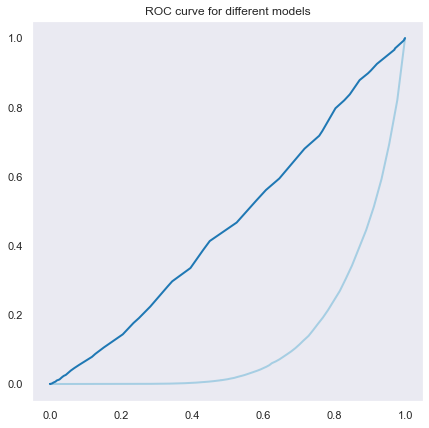

In [102]:
plot_compare_model_performance(algo_metrics, dataOrigTest)

Because of some error, we need to reflect each curve about the dotted line to get the true answer.

Or, just take 1-the area from the legend to get the actual AUROC

Notice that Adversarial Debiasing (when compiled) has a relatively **low** AUROC, which means that de-biasing has a tradeoff of potentially less accuracy.